In [5]:
import numpy as np
import pandas as pd
from numba import jit #Use for kappa_cohen function

#Ploting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Prediction model
import lightgbm as lgb
import xgboost as xgb

#Model selection and metric
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Utility
from collections import Counter
import re
from tqdm import tqdm
from typing import Any
import copy
import time

import warnings
warnings.filterwarnings("ignore") #Turn off warning
import gc; gc.enable() #Garbage Collector

In [6]:
#Display setting to see everything in each row
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 600)

In [7]:
gc.collect()

59

## Helper functions and classes

In [9]:
def add_datepart(df: pd.DataFrame, field_name: str,
                 prefix: str = None, drop: bool = True, time: bool = True, date: bool = True):
    """
    Helper function that adds columns relevant to a date in the column `field_name` of `df`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/tabular/transform.py#L55
    """
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
    if date:
        attr.append('Date')
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower())
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df


def ifnone(a: Any, b: Any) -> Any:
    """`a` if `a` is not None, otherwise `b`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/core.py#L92"""
    return b if a is None else a

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred, ):
    """
    Fast cappa eval function for lgb.
    """
    coefficients=[1.14922812, 1.72166408, 2.18804114] # Can change it later using Optimizer rounder
    
    y_pred[y_pred <= coefficients[0]] = 0
    y_pred[np.where(np.logical_and(y_pred > coefficients[0], y_pred <= coefficients[1]))] = 1
    y_pred[np.where(np.logical_and(y_pred > coefficients[1], y_pred <= coefficients[2]))] = 2
    y_pred[y_pred > coefficients[2]] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

# Wrapper of LGB

In [11]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

# Regressor Model

In [54]:
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')


In [32]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.datasets import make_classification

# Import preprocessed data

In [16]:
ls output/

X_test.csv   X_train.csv  label.csv


In [18]:
#Import official data
X_test = pd.read_csv("output/X_test.csv")
X_train = pd.read_csv("output/X_train.csv")
label = pd.read_csv("output/label.csv")
sample_submission=pd.read_csv('input/sample_submission.csv')

X_train=X_train.drop(['ASM_GT','ASM_accuracy','ASM_correct', 'ASM_incorrect'],axis=1)

# Modeling

In [36]:
#Smote
sm = SVMSMOTE(random_state=42)
X_train_new=X_train.drop(['Assessment_title', 'game_session', 'installation_id'], axis=1)
X_res, y_res = sm.fit_resample(X_train_new, label)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3156aef0>]],
      dtype=object)

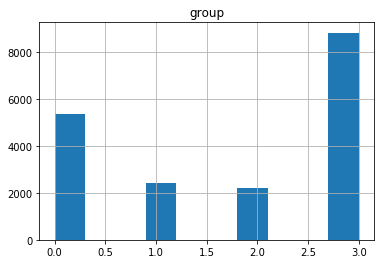

In [52]:
label.hist()

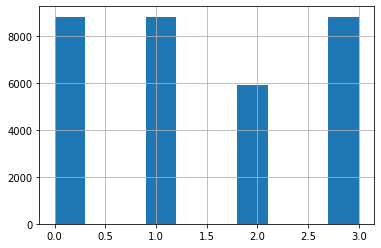

In [39]:
pd.Series(y_res).hist()

In [19]:
params = {'n_estimators':2000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.04,
            'feature_fraction': 0.9,
         'max_depth': 15,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            'verbose': 100,
            'early_stopping_rounds': 100, 'eval_metric': 'cappa'
            }

In [45]:
X_res_new=pd.DataFrame(X_res)

Fold 1 started at Wed Dec  4 11:53:09 2019
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.519206	train's cappa: 0.899015	valid's rmse: 0.607316	valid's cappa: 0.853378
[200]	train's rmse: 0.461639	train's cappa: 0.92064	valid's rmse: 0.593252	valid's cappa: 0.855046
[300]	train's rmse: 0.427136	train's cappa: 0.93218	valid's rmse: 0.592229	valid's cappa: 0.854978
Early stopping, best iteration is:
[223]	train's rmse: 0.453604	train's cappa: 0.923454	valid's rmse: 0.593079	valid's cappa: 0.856597
Fold 2 started at Wed Dec  4 11:53:18 2019
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.527351	train's cappa: 0.896341	valid's rmse: 0.5694	valid's cappa: 0.874491
[200]	train's rmse: 0.471068	train's cappa: 0.91755	valid's rmse: 0.555916	valid's cappa: 0.876147
[300]	train's rmse: 0.436135	train's cappa: 0.929598	valid's rmse: 0.55157	valid's cappa: 0.877369
[400]	train's rmse: 0.407914	train's cappa: 0.938348	valid'

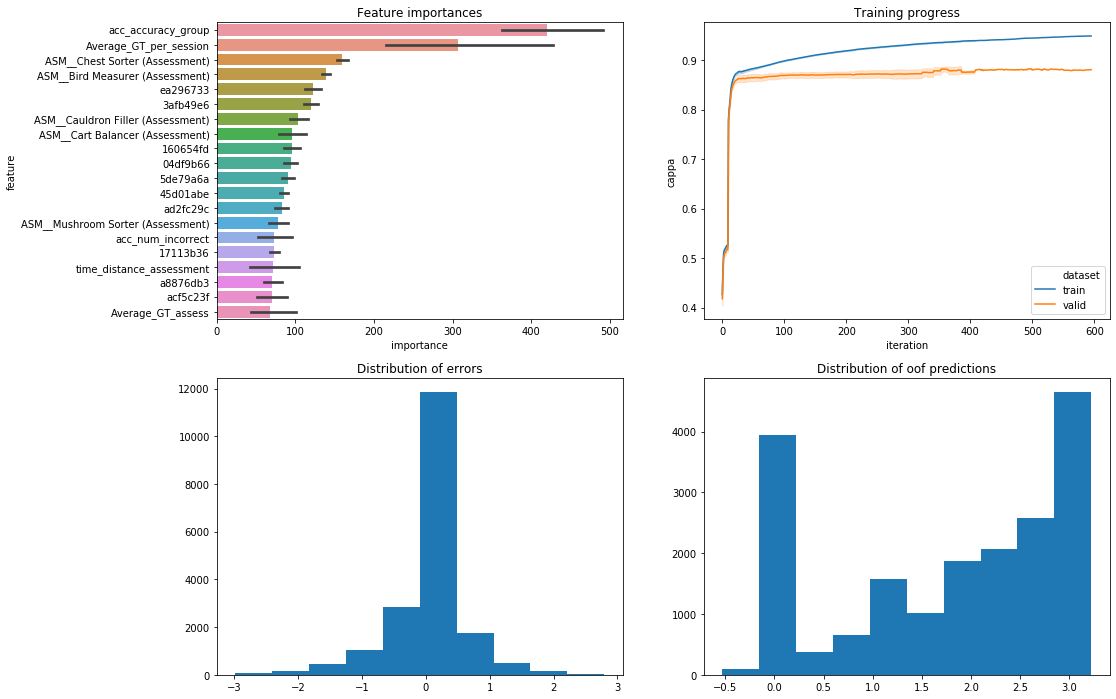

In [55]:
n_fold = 10
folds = GroupKFold(n_splits=n_fold)
cols_to_drop = ['Assessment_title', 'game_session', 'installation_id']

mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model1 = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model1.fit(X=X_train, y=label, folds=folds, params=params, 
                     preprocesser=mt, transformers=transformers, cols_to_drop=cols_to_drop, eval_metric='cappa' )


# Prediction

In [23]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [24]:
test_installation=X_test.installation_id
X_test=X_test[X_train.columns]

In [25]:
%%time
pr1 = regressor_model1.predict(X_train)
optR = OptimizedRounder()
optR.fit(pr1.reshape(-1,), label)
coefficients = optR.coefficients()
coefficients

CPU times: user 23.4 s, sys: 838 ms, total: 24.2 s
Wall time: 19.4 s


array([0.87888836, 1.65501505, 2.36566225])

In [26]:
#Using optimizer coefficient to set the threshold
pr1 = regressor_model1.predict(X_test)
pr1[pr1 <= coefficients[0]] = 0
pr1[np.where(np.logical_and(pr1 > coefficients[0], pr1 <= coefficients[1]))] = 1
pr1[np.where(np.logical_and(pr1 > coefficients[1], pr1 <= coefficients[2]))] = 2
pr1[pr1 > coefficients[2]] = 3
pr1=pd.Series([i[0] for i in pr1]) #flat it

In [27]:
pd.Series(pr1).value_counts()

0.0    571
3.0    279
2.0    101
1.0     49
dtype: int64

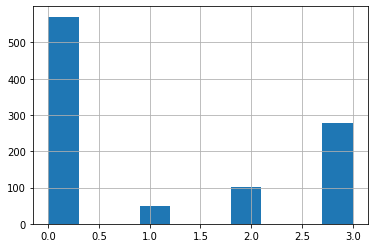

In [28]:
pd.Series(pr1).hist()
plt.show()

In [29]:
print('Percentage of readiness:', (sample_submission.installation_id==test_installation).sum()*100/1000)

Percentage of readiness: 100.0


In [61]:
# sample_submission['accuracy_group'] = pr1.astype(int)
# sample_submission.to_csv('submission.csv', index=False)